# Knapsack

__Alunos:__
- Eduardo Villani - 2015104008
- Hugo Zanini - 2015016044
---

Problema: Dada uma mochila com uma capacidade máxima CAP, devemos colocar N objetos nela consideram
seu valor V e seu P, dado que não ultrapassemos CAP e maximizemos o valor total dos objetos colocados na mochila.

Podemos resolver esse problema por meio de um algoritmo com N genes, variando entre 0 e 1, onde 0 representa um objeto
não colocado e 1 representa um objeto colocado na mochila. Para calcularmos o fitness de um indivíduo, usamos as seguinte fórmulas:


$V(x) = \sum_{i=1}^{N}= v_ix_i$

$P(x) = \sum_{i=1}^{N}= w_ix_i$

$Pen(x) = 0$, se x é invalida

$Pen(x) = pP(x)$, caso contrario

$p = max \frac{v_i}{w_i}$

$f(x) = V(x) - Pen(x)$

Os mecanismos utilizados para a solução foram os seguintes: Selecionar N pais utilizando a seleção de roleta,
cruzar com 1 ponto de corte com probabilidade > 0.6, seguido de Bit Flip com probabilidade entre 0.02 e 0.1 e sobreviventes
geracionais, com todos os filhos sendo substituídos. Também, antes de selecionar os país, descartamos os piores fitness.
A condição de parada é tal que, após 12 gerações em que o fitness não muda e a Capacidade é menor que o máximo, chegamos a resposta desejada.

## Solução
---
### Algortimo genético
1. Inicie uma população com N individuos, cada um de tamanho K e genes com valor 0 ou 1;
2. Calcule o fit da população;
3. Enquanto não tivermos o máximo de iterações ou o melhor fit, abaixo da MAX_CAPACITY, não se altere durante *G* gerações faça:

    3.1 Selecione os país por ranqueamento + roleta;

    3.2 Gere os filhos;

    3.2.1 Primeiro com crossover com probabilidade *p*;

    3.2.2 Seguido de bitflip com probabilidae 0.02 < *p'* < 0.1;

    3.3 Junte os filhos e país;

    3.4 Selecione todos usando 3.1;

    3.5. Remova os menos aptos;

    3.6 Gere a nova geração com pais + filhos

    3.7 Volte para 3;

---

### Código

In [2]:
import warnings
from random import randint, uniform

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import MatplotlibDeprecationWarning
from scipy.stats import rankdata


class KnapsackProblem:
    def __init__(self, obj, capacity, num_population, max_iters=10000, max_gen_to_converge=10, penalty=1):
        self.num_population = num_population
        self.max_iters = max_iters
        self.max_gen_to_converge = max_gen_to_converge
        self.obj = obj
        self.capacity = capacity
        self.penalty = penalty
        self._gens = []

    @property
    def data_per_gen(self):
        return np.array(self._gens)

    def solve(self, verbose=False, get_best_proportion=0.1):
        num_population = self.num_population
        max_iters = self.max_iters
        population = np.array([KnapsackProblem.init_items(self.obj) for _ in range(num_population)])
        max_gen_to_converge = self.max_gen_to_converge
        last_max_fit = 0
        hit = 0

        for i in range(max_iters):
            fitness_per_being = np.array(
                [KnapsackProblem.fitness_function(self.obj, p, self.capacity, self.penalty) for p in population])
            index = np.argmax(fitness_per_being)

            if verbose:
                print(f"Generation {i}")
                print(f"Better Fitness {fitness_per_being[index]}")
                print(f"Better Being: {population[index]}")
                print(f"Current Capacity: {KnapsackProblem.current_cap(self.obj, population[index])}")
                print(f"Current Value: {KnapsackProblem.value_in_bag(self.obj, population[index])}\n")

            if hit >= max_gen_to_converge:
                break
            hit = KnapsackProblem.count_hits(fitness_per_being, hit, index, last_max_fit, population, verbose, self.obj, self.capacity)
            # Save data for analyse
            self._gens.append(
                [
                    i,
                    max(fitness_per_being),
                    np.mean(fitness_per_being),
                    KnapsackProblem.current_cap(self.obj, population[index]),
                    len(population)
                ]
            )

            last_max_fit = fitness_per_being[index]

            selected_parents = KnapsackProblem.fitness_roulette_selector(num_population, population, fitness_per_being)
            children = KnapsackProblem.gen_children(selected_parents)
            population = self.gen_new_population(children, get_best_proportion, population, self.obj, self.penalty, self.capacity)

    @staticmethod
    def gen_new_population(children, get_best_proportion, population, obj, penalty, capacity):
        next_gen = KnapsackProblem.generation_selection(population, children)
        next_gen_fit = np.array(
                [KnapsackProblem.fitness_function(obj, p, capacity, penalty) for p in next_gen]
        )

        fitness_per_being, population = KnapsackProblem.get_proportional_best_fitness(
            get_best_proportion,
            next_gen_fit,
            next_gen
        )
        return population

    @staticmethod
    def get_proportional_best_fitness(get_best_proportion, fitness_per_being, population):
        proportion = get_best_proportion
        # Get x% values
        fitness_per_being, population = KnapsackProblem.sort_population_by_fit(population, fitness_per_being)
        population = population[:int(len(population) * proportion)]
        fitness_per_being = fitness_per_being[:int(len(fitness_per_being) * proportion)]
        return fitness_per_being, population

    @staticmethod
    def count_hits(fitness_per_being, hit, index, last_max_fit, population, verbose, objs, capacity):
        def compare_fits():
            def equal_last():
                return last_max_fit == fitness_per_being[index]

            def bigger_last():
                return last_max_fit < fitness_per_being[index]

            return equal_last() or bigger_last()

        def valid_capacity():
            return KnapsackProblem.current_cap(objs, population[index]) <= capacity

        if compare_fits() and valid_capacity():
            hit += 1
            if verbose:
                print(f'Hit: {hit}')
        else:
            hit = 0
        return hit

    @staticmethod
    def gen_children(selected_parents):
        children = KnapsackProblem.crossover(selected_parents)
        children = KnapsackProblem.bit_flip(children)
        return children

    @staticmethod
    def init_items(objs):
        return np.array([randint(0, 1) for _ in objs])

    @staticmethod
    def current_cap(obj, items_in_bag):
        return items_in_bag @ obj.T[0]

    @staticmethod
    def value_in_bag(obj, items_in_bag):
        return items_in_bag @ obj.T[1]

    @staticmethod
    def penalty_function(obj, items_in_bag, capacity, penalty=1):
        def penalty_proportion(obj):
            return penalty * max((obj.T[1] / obj.T[0]))

        cap = KnapsackProblem.current_cap(obj, items_in_bag)
        if cap > capacity:
            return penalty_proportion(obj) * (cap - capacity)
        else:
            return 0

    @staticmethod
    def fitness_function(obj, items_in_bag, capacity, penalty=1):
        fit = KnapsackProblem.value_in_bag(obj, items_in_bag) - KnapsackProblem.penalty_function(
            obj,
            items_in_bag,
            capacity,
            penalty
        )
        return fit

    @staticmethod
    def sort_population_by_fit(population, fitness_per_being):
        k = np.vstack((population.T, fitness_per_being)).T
        k = k[np.argsort(-k[:, -1])]

        fitness_per_being = k[:, -1]
        population = k[:, :-1]
        return fitness_per_being, population

    @staticmethod
    def fitness_roulette_selector(n_been, population, fitness_per_being):
        def roulette_selector_per_been(population, fitness_per_being):
            ranking = KnapsackProblem.rank_population(fitness_per_being)
            linear_ranking = KnapsackProblem.linear_rank(len(fitness_per_being), ranking)
            picker = uniform(0, 1)
            index = np.where(np.cumsum(linear_ranking) >= picker)[0][0]
            return population[index]

        selected_parents = np.array(
            [roulette_selector_per_been(population, fitness_per_being) for _ in range(int(n_been))])
        return np.array_split(np.array(selected_parents), len(selected_parents) / 2)

    @staticmethod
    def crossover(parents):
        def action(parent_1, parent_2):
            prob_crossover = uniform(0, 1)
            if prob_crossover > 0.6:
                return [parent_1, parent_2]
            cut_point = randint(0, len(parent_1))
            children_1 = np.concatenate((parent_1[: cut_point], parent_2[cut_point:]))
            children_2 = np.concatenate((parent_2[: cut_point], parent_1[cut_point:]))
            return [children_1, children_2]

        return np.array([action(*parent) for parent in parents]).reshape(len(parents) * 2, len(parents[0][0]))

    @staticmethod
    def bit_flip(childrens):
        def action(children):
            for index, bit in enumerate(children):
                if uniform(0, 1) <= 0.1:
                    if bit == 1:
                        children[index] = 0
                    elif bit == 0:
                        children[index] = 1
            return children

        return np.array([action(children) for children in childrens])

    def plot(self):
        warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
        plt.plot(self.data_per_gen.T[0], self.data_per_gen.T[2], '-', label='Fitness médio')
        plt.xlabel('Geração')
        plt.ylabel('Fitness')
        plt.plot(self.data_per_gen.T[0], self.data_per_gen.T[1], '-', label='Fitness máximo')
        plt.legend(loc="upper left")
        plt.title('Evolução do fitness médio e máximo')
        plt.subplot(111).legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    @staticmethod
    def rank_population(fit_per_being):
        return np.array(rankdata(fit_per_being, method='ordinal') - 1)

    @staticmethod
    def linear_rank(n_pop, ranking, s=1.5):
        return ((2 - s) / n_pop) + ((2 * ranking) * (s - 1)) / (n_pop * (n_pop - 1))

    @staticmethod
    def generation_selection(parents, children):
        next_generation = np.concatenate((parents, children), axis=0)
        return next_generation

## Testes


##### O primeiro teste consiste em manter a população incial com os objetos de testes, mas variar o
número de gerações para convergir

### N = 10 e MAX = 10

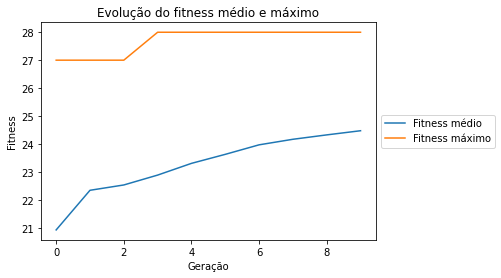

In [3]:
max_capacity = 50
objs = np.array([
    [10, 5],
    [18, 8],
    [12, 7],
    [14, 6],
    [13, 9],
    [11, 5],
    [8, 4],
    [6, 3]
]
)


bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=10,
        max_gen_to_converge=10,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 10 e MAX = 50

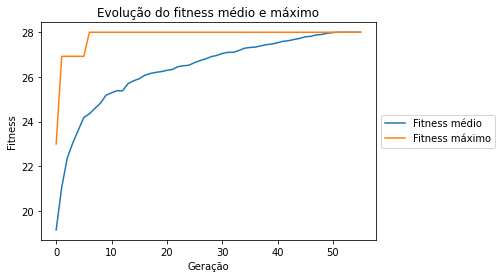

In [4]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=10,
        max_gen_to_converge=50,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 10 e MAX = 100

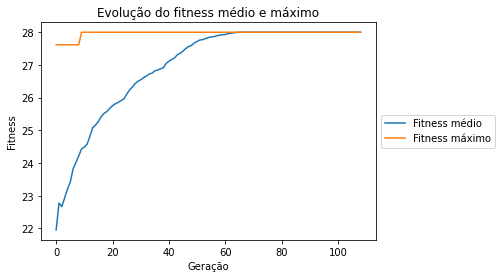

In [5]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=10,
        max_gen_to_converge=100,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 50 e MAX = 10

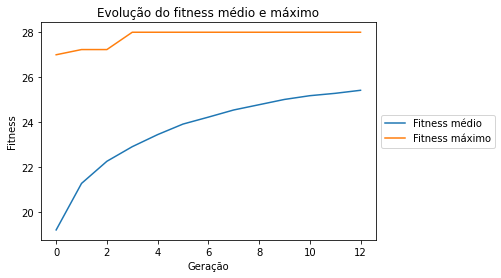

In [6]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=50,
        max_gen_to_converge=10,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 50 e MAX = 50

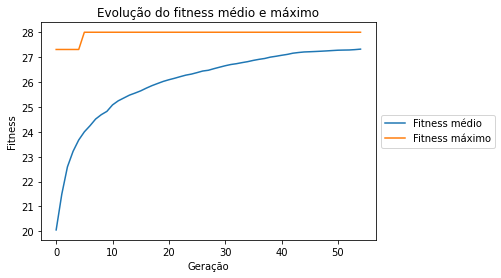

In [7]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=50,
        max_gen_to_converge=50,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 50 e MAX = 100

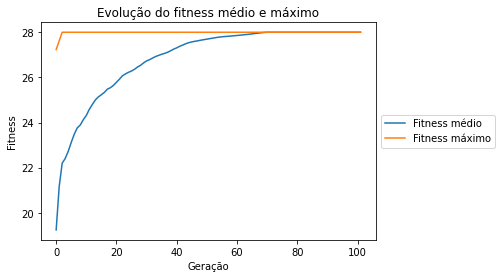

In [8]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=50,
        max_gen_to_converge=100,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()

### N = 100 e MAX = 10

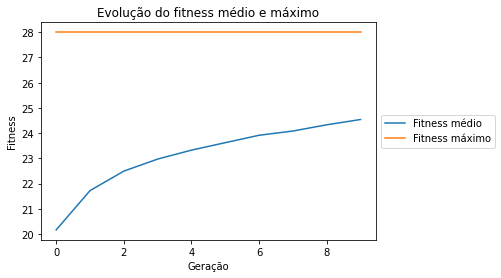

In [9]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=10,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()


### N = 100 e MAX = 50

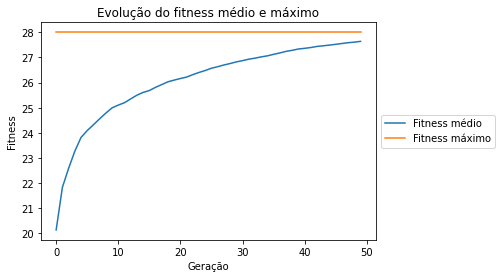

In [10]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()


### N = 100 e MAX = 100

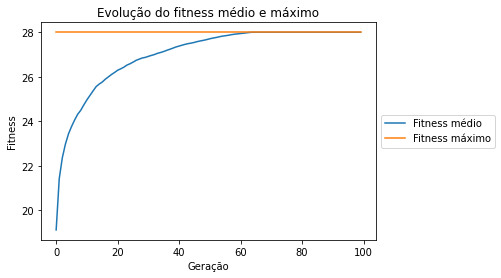

In [11]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
)
bag.solve(
        False,
        0.9
    )

bag.plot()



##### O próximo teste consiste em variar o valor da proporção das soluções que vão para a próxima geração em 1.0, 0.5, 0.1

### N = 100 e proportion = 1.0

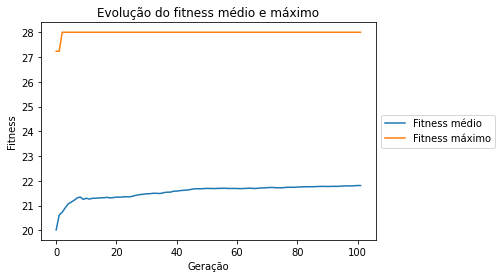

In [12]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
)
bag.solve(
        False,
        1
    )

bag.plot()


### N = 100 e proportion = 0.5

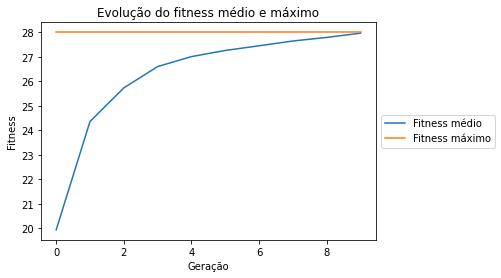

In [13]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=10,
        penalty=1
)
bag.solve(
        False,
        0.5
    )

bag.plot()


### N = 100 e proportion = 0.1

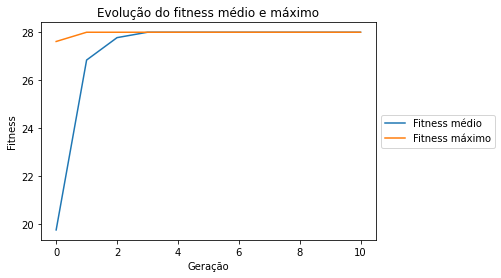

In [14]:
bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=10,
        penalty=1
)
bag.solve(
        False,
        0.1
    )

bag.plot()


##### O último teste se trata da procura de soluções para dados aletórios para K = 10, 20, 50, 100


### K = 10

Max Capacity for K = 10: 339
Number of Gens to solve: 50


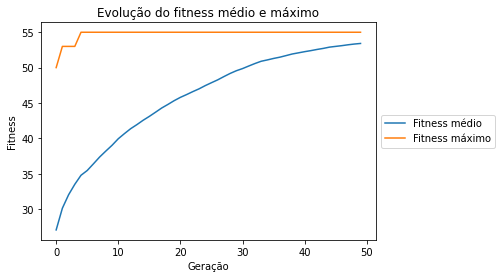

In [37]:
    k = 10
    max_capacity, objs = ObjetsGenerator(k)
    print(f'Max Capacity for K = {k}: {max_capacity}')
    bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
    )
    bag.solve(
        False,
        0.9
    )
    print(f'Number of Gens to solve: {len(bag.data_per_gen)}')
    bag.plot()

### K = 20

In [16]:
class ObjetsGenerator:
    def __new__(cls, k):
        values = [randint(1, 10) for _ in range(k)]
        weights = [randint(5, 30) for _ in range(k)]
        max_capacity = randint(min(weights), int(max(weights) * np.mean(weights)))
        objs = np.array([[weights[i], values[i]] for i in range(k)])
        return max_capacity, objs

Max Capacity for K = 20: 133
Number of Gens to solve: 50


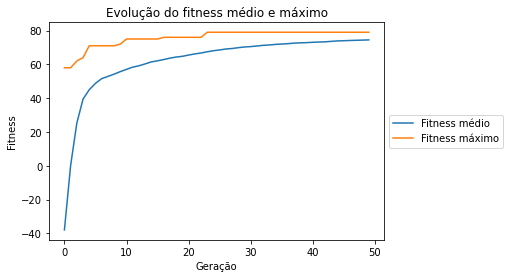

In [31]:
    k = 20
    max_capacity, objs = ObjetsGenerator(k)
    print(f'Max Capacity for K = {k}: {max_capacity}')
    bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
    )
    bag.solve(
        False,
        0.7
    )
    print(f'Number of Gens to solve: {len(bag.data_per_gen)}')
    bag.plot()

### K = 50

Max Capacity for K = 50: 494
Number of Gens to solve: 55


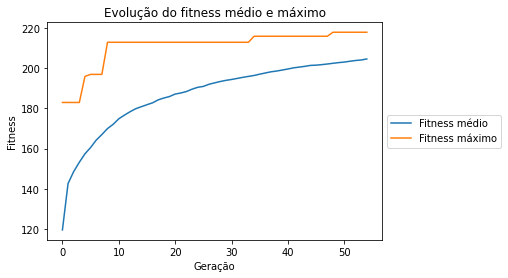

In [27]:
    k = 50
    max_capacity, objs = ObjetsGenerator(k)
    print(f'Max Capacity for K = {k}: {max_capacity}')
    bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
    )
    bag.solve(
        False,
        0.7
    )
    print(f'Number of Gens to solve: {len(bag.data_per_gen)}')
    bag.plot()

### K = 100

Max Capacity for K = 100: 289
Number of Gens to solve: 200


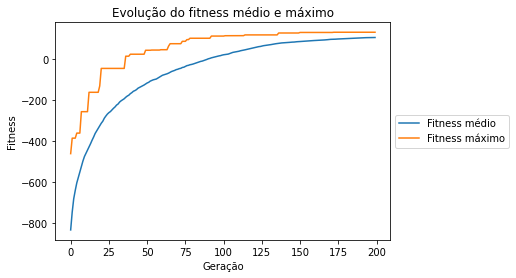

In [30]:
    k = 100
    max_capacity, objs = ObjetsGenerator(k)
    print(f'Max Capacity for K = {k}: {max_capacity}')
    bag = KnapsackProblem(
        obj=objs,
        capacity=max_capacity,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
    )
    bag.solve(
        False,
        0.7
    )
    print(f'Number of Gens to solve: {len(bag.data_per_gen)}')
    bag.plot()


## Conclusões

Foi possivel notar a forma como parametros de escolha alteram o resultado. Primeiramente a quantidade inicial
da população de soluções que, quanto maior o número, mais rápido convergimos para uma resposta. Também foi
possivel notar que a forma da curva de fitnesse médio é impactado pela quantidade de soluções que são mantidas,
podendo ser mais aberta ou mais fechada. Por último, como o tamanho da mochila impacta a número de gerações para convergimos
para uma resposta.